In [1]:
import torch

In [2]:
print(torch.cuda.is_available())

True


In [3]:

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

In [4]:
# Define the paths to your raw and augmented data directories
raw_data_dir = r'C:\Users\user\Desktop\Minor sem 6\Laptop Components Image Dataset to Classify Different Components\Raw Data\Raw Data'  # Replace with the actual path to your raw data directory
augmented_data_dir = r'C:\Users\user\Desktop\Minor sem 6\Laptop Components Image Dataset to Classify Different Components\Augmented Data\Augmented Data'  # Replace with the actual path to your augmented data directory

In [5]:
# Define transformations for training and validation data
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),  # Resize images
    transforms.RandomRotation(30),  # Random rotations for augmentation
    transforms.RandomHorizontalFlip(),  # Random horizontal flips
    transforms.RandomVerticalFlip(),  # Random vertical flips
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization (ImageNet stats)
])

validation_transforms = transforms.Compose([
    transforms.Resize((224,224)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Load data using ImageFolder and DataLoader
train_data = datasets.ImageFolder(root=augmented_data_dir, transform=train_transforms)  # use augmneted data for training
valid_data = datasets.ImageFolder(root=raw_data_dir, transform=validation_transforms)  # use raw data for validation 

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers = 4)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle= True, num_workers = 4)

In [6]:
# Load the pre-trained Efficientnet
model = models.efficientnet_b0(pretrained=True)

# Modify the final layer to fit the number of categories (26 in your case)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 26)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

D:\hehe\envs\pytorch2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\hehe\envs\pytorch2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\user/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 45.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Mixed Precision Scaler
scaler = GradScaler()

# Loss function
criterion = nn.CrossEntropyLoss()

C:\Users\user\AppData\Local\Temp\ipykernel_14380\2516987154.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [9]:
torch.cuda.empty_cache()

In [12]:
# Train the model for 30 epochs
epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training loop
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        images, labels = images.to(device), labels.to(device)
        
        # Enable mixed-precision training
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Scaler's backward pass
        scaler.scale(loss).backward()
        
        # Optimizer step
        scaler.step(optimizer)
        
        # Update the scaler
        scaler.update()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Log the average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Log validation loss and accuracy
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Step the scheduler
    scheduler.step()

    # Save checkpoint (optional)
    torch.save(model.state_dict(), f"efficientnet_epoch_{epoch+1}.pth")
    
print("Training complete!")

Epoch 1/30:   0%|                                                                              | 0/797 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14380\354494162.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:01<00:00,  4.39it/s]


Training Loss: 0.0888, Training Accuracy: 97.17%


Validating:   0%|                                                                              | 0/114 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14380\354494162.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:41<00:00,  2.74it/s]


Validation Loss: 0.0191, Validation Accuracy: 99.53%


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0579, Training Accuracy: 98.23%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0128, Validation Accuracy: 99.67%


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0484, Training Accuracy: 98.54%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.69it/s]


Validation Loss: 0.0144, Validation Accuracy: 99.51%


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0350, Training Accuracy: 98.94%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.69it/s]


Validation Loss: 0.0168, Validation Accuracy: 99.45%


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.23it/s]


Training Loss: 0.0319, Training Accuracy: 99.05%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0028, Validation Accuracy: 99.89%


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0286, Training Accuracy: 99.12%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0058, Validation Accuracy: 99.86%


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0255, Training Accuracy: 99.26%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0013, Validation Accuracy: 100.00%


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.23it/s]


Training Loss: 0.0196, Training Accuracy: 99.40%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0061, Validation Accuracy: 99.84%


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████| 797/797 [03:07<00:00,  4.25it/s]


Training Loss: 0.0189, Training Accuracy: 99.46%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0033, Validation Accuracy: 99.92%


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0195, Training Accuracy: 99.42%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0021, Validation Accuracy: 99.95%


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0097, Training Accuracy: 99.73%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.67it/s]


Validation Loss: 0.0007, Validation Accuracy: 100.00%


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0072, Training Accuracy: 99.82%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.67it/s]


Validation Loss: 0.0003, Validation Accuracy: 100.00%


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0061, Training Accuracy: 99.83%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0004, Validation Accuracy: 99.97%


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.23it/s]


Training Loss: 0.0054, Training Accuracy: 99.84%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0004, Validation Accuracy: 99.97%


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0043, Training Accuracy: 99.89%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0004, Validation Accuracy: 99.97%


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0034, Training Accuracy: 99.93%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.68it/s]


Validation Loss: 0.0002, Validation Accuracy: 100.00%


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.22it/s]


Training Loss: 0.0041, Training Accuracy: 99.87%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0001, Validation Accuracy: 100.00%


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0039, Training Accuracy: 99.92%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.68it/s]


Validation Loss: 0.0001, Validation Accuracy: 100.00%


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0031, Training Accuracy: 99.93%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:41<00:00,  2.76it/s]


Validation Loss: 0.0001, Validation Accuracy: 100.00%


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0029, Training Accuracy: 99.91%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.69it/s]


Validation Loss: 0.0002, Validation Accuracy: 100.00%


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:07<00:00,  4.26it/s]


Training Loss: 0.0029, Training Accuracy: 99.91%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.68it/s]


Validation Loss: 0.0001, Validation Accuracy: 100.00%


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0037, Training Accuracy: 99.88%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:41<00:00,  2.72it/s]


Validation Loss: 0.0002, Validation Accuracy: 100.00%


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.22it/s]


Training Loss: 0.0032, Training Accuracy: 99.92%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0001, Validation Accuracy: 100.00%


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0025, Training Accuracy: 99.94%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0001, Validation Accuracy: 100.00%


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0029, Training Accuracy: 99.93%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.69it/s]


Validation Loss: 0.0002, Validation Accuracy: 100.00%


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0028, Training Accuracy: 99.93%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0003, Validation Accuracy: 99.97%


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.23it/s]


Training Loss: 0.0024, Training Accuracy: 99.93%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.70it/s]


Validation Loss: 0.0003, Validation Accuracy: 99.97%


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:09<00:00,  4.21it/s]


Training Loss: 0.0023, Training Accuracy: 99.94%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


Validation Loss: 0.0002, Validation Accuracy: 100.00%


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.22it/s]


Training Loss: 0.0026, Training Accuracy: 99.93%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:41<00:00,  2.72it/s]


Validation Loss: 0.0003, Validation Accuracy: 99.97%


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████| 797/797 [03:08<00:00,  4.23it/s]


Training Loss: 0.0032, Training Accuracy: 99.88%


Validating: 100%|████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]

Validation Loss: 0.0003, Validation Accuracy: 99.97%
Training complete!


In [13]:
torch.save(model, 'model.pth')

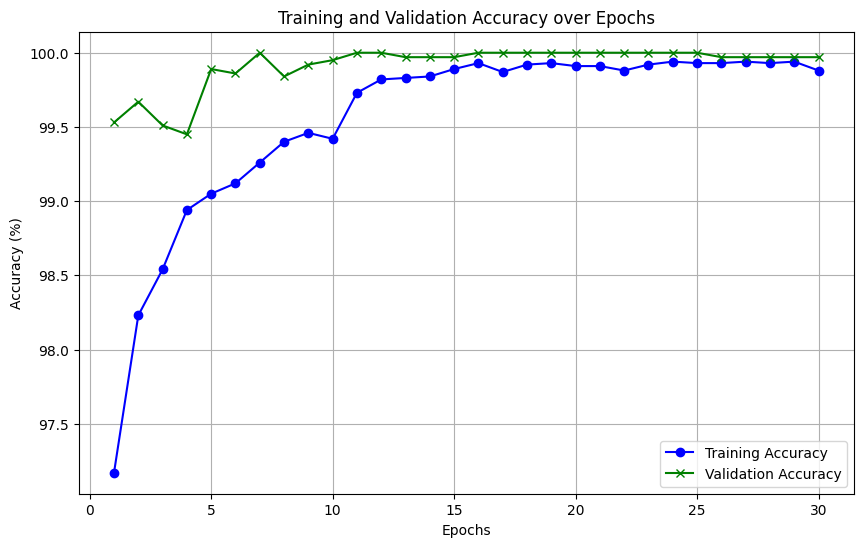

In [14]:
import matplotlib.pyplot as plt

# Example data for training and validation accuracy
# Replace these lists with your actual training and validation accuracy data
training_accuracies = [97.17, 98.23, 98.54, 98.94, 99.05, 99.12, 99.26, 99.40, 99.46, 99.42, 99.73, 99.82, 99.83, 99.84, 99.89, 99.93, 99.87, 99.92, 99.93, 99.91, 99.91, 99.88, 99.92, 99.94, 99.93, 99.93, 99.94, 99.93, 99.94, 99.88]
validation_accuracies = [99.53, 99.67, 99.51, 99.45, 99.89, 99.86, 100.00, 99.84, 99.92, 99.95, 100.00, 100.00, 99.97, 99.97, 99.97, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 99.97, 99.97, 99.97, 99.97, 99.97]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot training and validation accuracies
plt.plot(range(1, 31), training_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, 31), validation_accuracies, label='Validation Accuracy', color='green', marker='x')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()